# Skin Cancer Detection

## Dependencies

In [ ]:
import pandas as pd
import os
import shutil
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time
import torch.nn.functional as F


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

################################

data_dir = '/data/ham10000-skin-cancer/'
metadata_path = os.path.join(data_dir, 'HAM10000_metadata.csv')
images_dir = os.path.join(data_dir, 'HAM10000_images_part_1')
images_dir_2 = os.path.join(data_dir, 'HAM10000_images_part_2')

# image_files = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.jpg')]
# image_files += [os.path.join(images_dir_2, f) for f in os.listdir(images_dir_2) if f.endswith('.jpg')]
# print(f"Number of images: {len(image_files)}")

destination_folder = os.path.join(data_dir, 'HAM10000_images_folder')
# copied_images = [os.path.join(destination_folder, f) for f in os.listdir(destination_folder) if f.endswith('.jpg')]
# print(f"Number of images: {len(copied_images)}")

saved = True

if not saved:
  if not os.path.exists(destination_folder):
      os.makedirs(destination_folder)

  for image_file in image_files:
      filename = os.path.basename(image_file)
      destination_path = os.path.join(destination_folder, filename)
      shutil.copyfile(image_file, destination_path)

  print("Images saved to", destination_folder)
  saved = True


Mounted at /content/drive


## Data Analysis

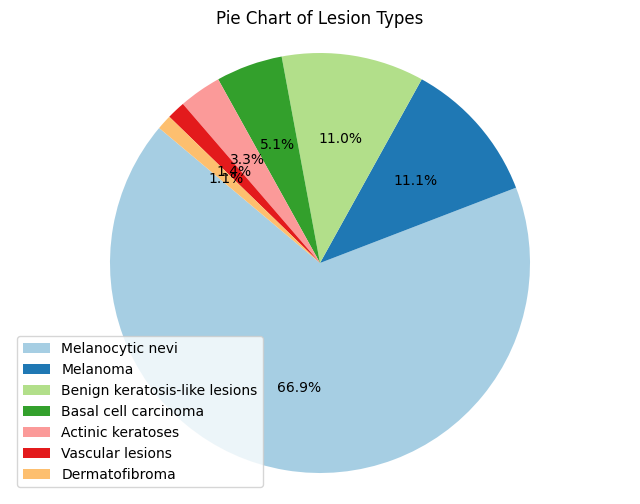

In [ ]:
metadata = pd.read_csv(metadata_path)

lesion_counts = metadata['dx'].value_counts()

lesion_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'bkl': 'Benign keratosis-like lesions',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

labels = [lesion_dict[code] for code in lesion_counts.index]
sizes = lesion_counts.values


# Plotting
plt.figure(figsize=(8,6))
wedges, texts, autotexts = plt.pie(lesion_counts, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(lesion_counts))))
#wedges, texts = plt.pie(lesion_counts, startangle=140, colors=plt.cm.Paired(range(len(lesion_counts))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Pie Chart of Lesion Types')
plt.legend(labels, loc="best")
plt.show()

### Only Run the Below Cell if New Metadata Needed

In [ ]:
# Define a mapping function to convert diagnosis to malignant or benign
def label_to_category(label):
    """""
    Convert diagnosis label to malignant or benign.
    """
    if label in ['akiec', 'bcc', 'mel']:
        return 'malignant'
    elif label in ['bkl', 'df', 'nv', 'vasc']:
        return 'benign'
    else:
        return 'unknown'  # In case there are any unexpected labels

# Apply the mapping function to the 'dx' column
metadata['diagnosis'] = metadata['dx'].apply(label_to_category)
metadata['diagnosis_idx'] = pd.Categorical(metadata['diagnosis']).codes

# Drop the original 'dx' column
metadata = metadata.drop('dx', axis=1)

# Save the modified dataframe to a new CSV file
new_metadata_path = os.path.join(data_dir, 'HAM10000_new_metadata.csv')  # Update this to your desired new CSV path
metadata.to_csv(new_metadata_path, index=False)

print(f"New metadata saved to {new_metadata_path}")


New metadata saved to /data/ham10000-skin-cancer/HAM10000_new_metadata.csv


### Continue

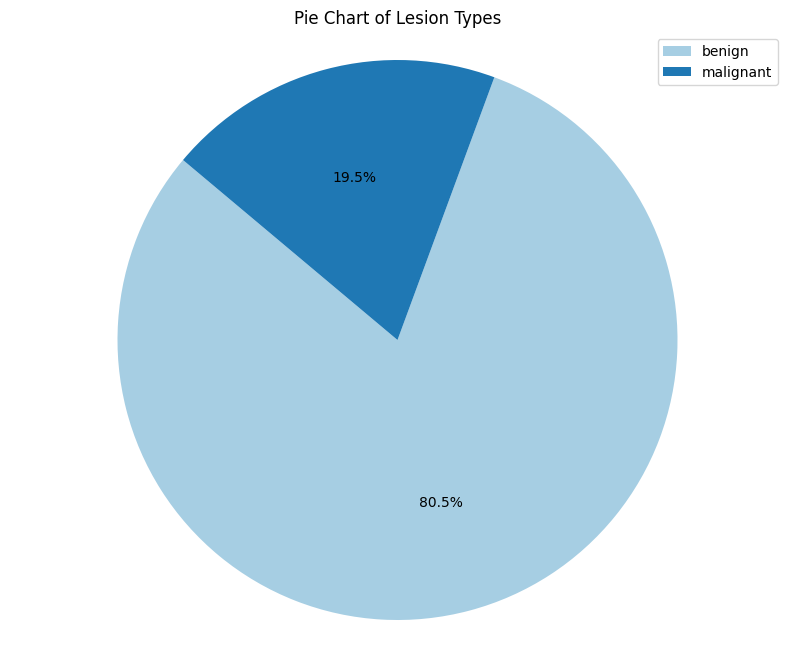

In [ ]:
new_metadata_path = os.path.join(data_dir, 'HAM10000_new_metadata.csv')
data = pd.read_csv(new_metadata_path)

lesion_counts = data['diagnosis'].value_counts()

labels = [code for code in lesion_counts.index]
sizes = lesion_counts.values

# Plotting
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(lesion_counts, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(lesion_counts))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Pie Chart of Lesion Types')
plt.legend(labels, loc="best")
plt.show()

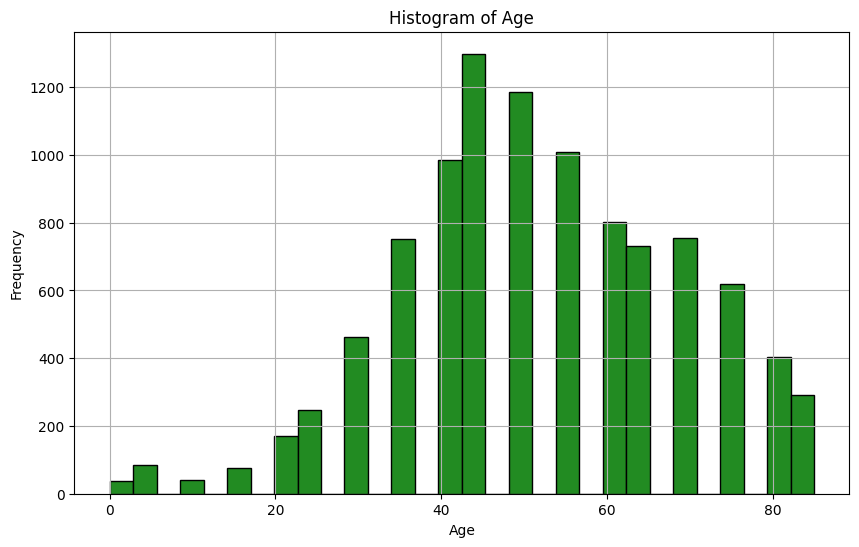

In [ ]:
# Histogram by Age
plt.figure(figsize=(10, 6))
plt.hist(data['age'].dropna(), bins=30, color='forestgreen', edgecolor='black')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

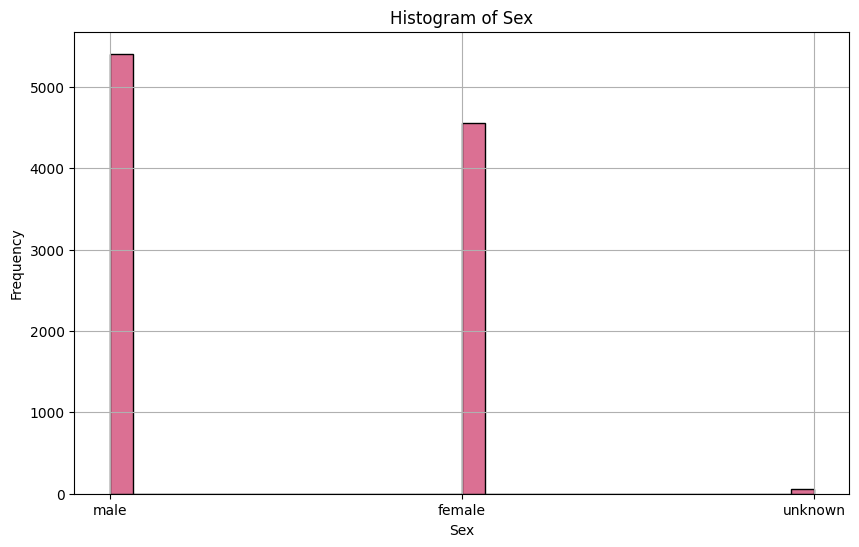

In [ ]:
# Histogram by Sex
plt.figure(figsize=(10, 6))
plt.hist(data['sex'].dropna(), bins=30, color='palevioletred', edgecolor='black')
plt.title('Histogram of Sex')
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

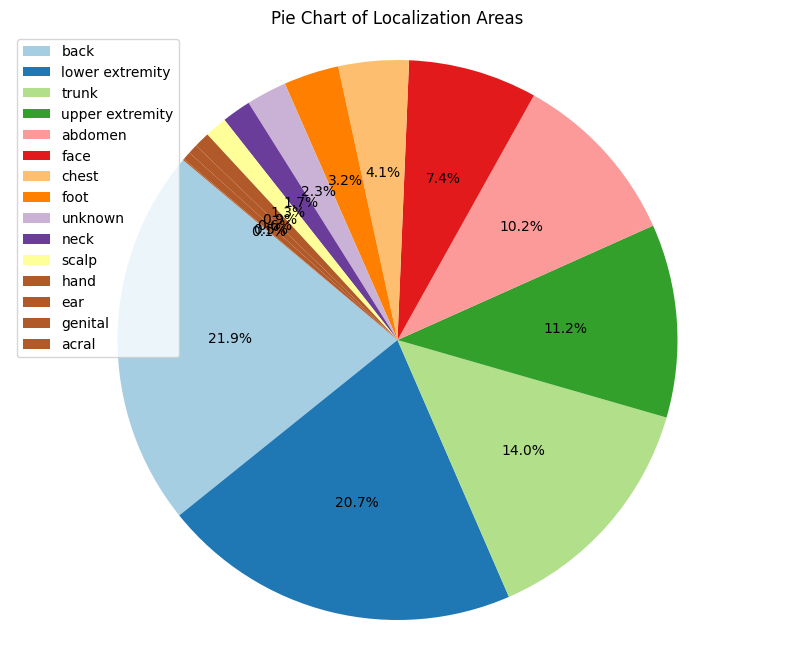

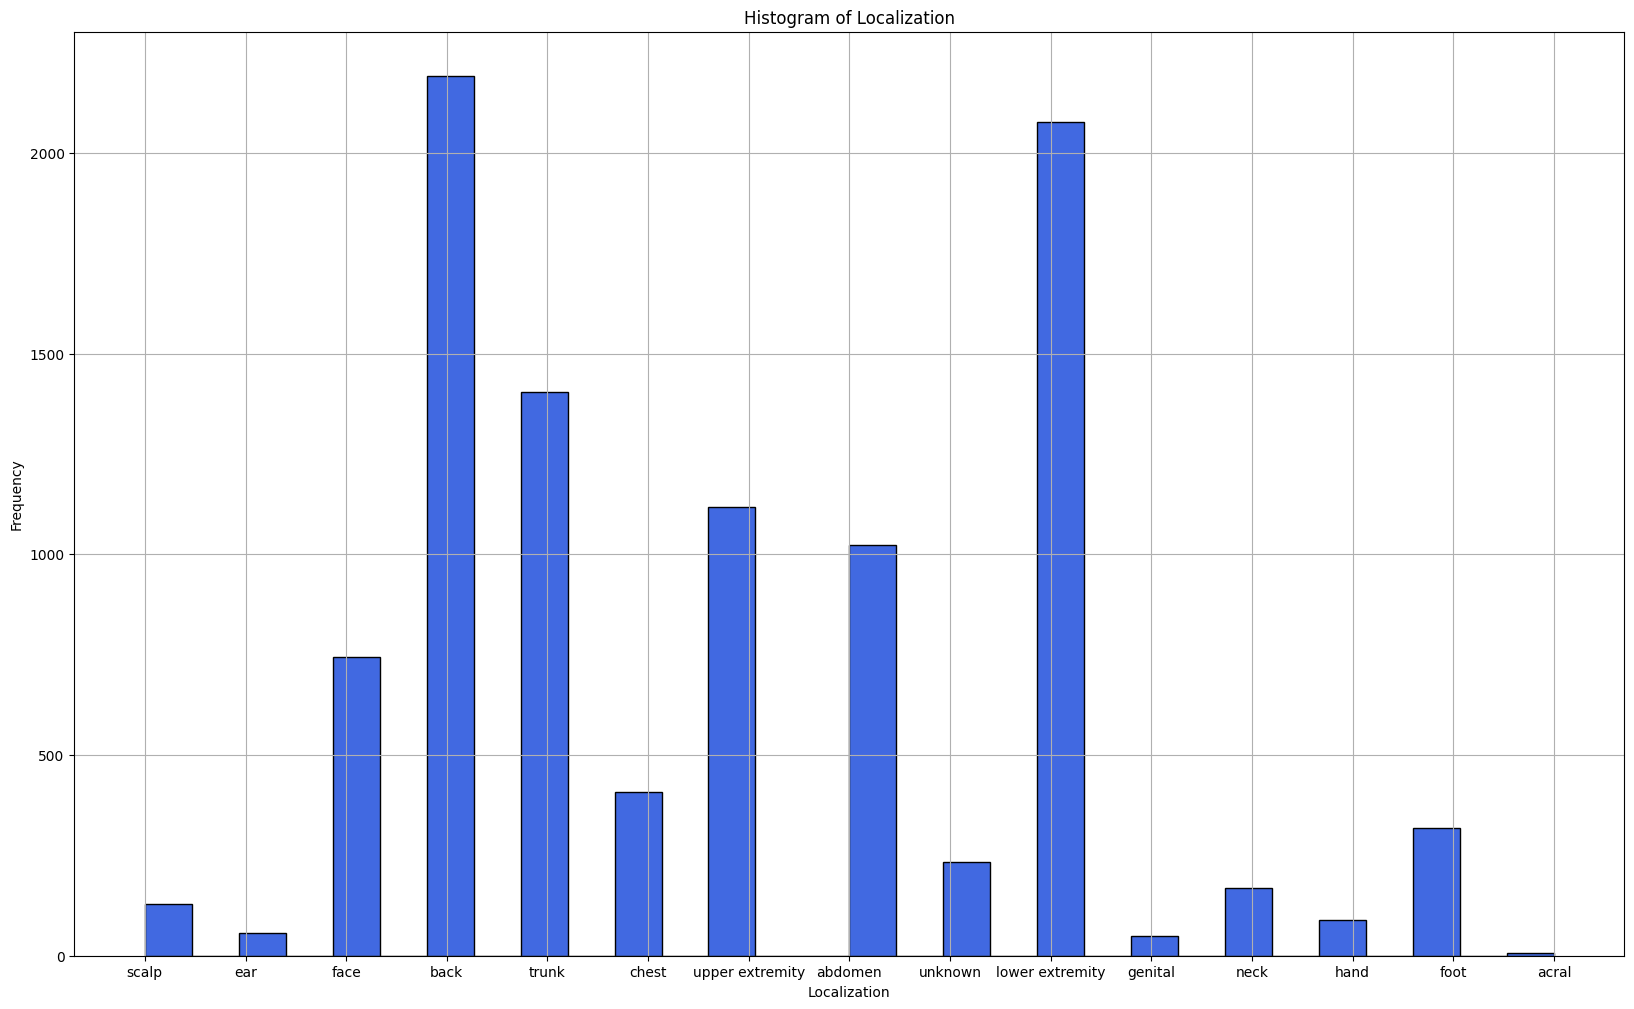

In [ ]:
# Localization
localizations = data['localization'].value_counts()
labels = [area for area in localizations.index]
sizes = localizations.values
# Plotting
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(localizations, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(localizations))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Pie Chart of Localization Areas')
plt.legend(labels, loc="best")
plt.show()

# Histogram by Localization Area
plt.figure(figsize=(20, 12))
plt.hist(data['localization'].dropna(), bins=30, color='royalblue', edgecolor='black')
plt.title('Histogram of Localization')
plt.xlabel('Localization')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
from random import seed, shuffle

def split_data(source_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    """""
    Split data into train, validation, and test sets.
    """
    # Ensure the percentages sum to 1
    assert (train_size + val_size + test_size) == 1

    # Make sure the directory exists and is not empty
    files = [os.path.join(source_dir, f) for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    if not files:
        print("No files found in the directory.")
        return

    # Shuffle files to ensure random distribution
    seed(42)
    shuffle(files)

    # Calculate split indices
    train_end = int(len(files) * train_size)
    val_end = train_end + int(len(files) * val_size)

    # Split files accordingly
    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    # Function to copy files to a new directory
    def copy_files(files, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)
        for f in files:
            shutil.copy(f, directory)

    # Copy files to respective directories
    copy_files(train_files, train_dir)
    copy_files(val_files, val_dir)
    copy_files(test_files, test_dir)
    print(f"Files distributed: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test.")

# Paths to your directories
source_directory = destination_folder
train_directory = os.path.join(data_dir, 'HAM10000_train')
val_directory = os.path.join(data_dir, 'HAM10000_val')
test_directory = os.path.join(data_dir, 'HAM10000_test')

split = True

if not split:
  split_data(source_directory, train_directory, val_directory, test_directory)


## Models and Training Infra

In [ ]:
def initialize_model(model_name, num_classes, resume_from = None, use_pretrained = False, pretrained_path=None):
    """
    Args:
        model_name: Name of the model to be initialized.
        num_classes: number of classes in the dataset.
        resume_from: Path to the weights to be loaded.
        use_pretrained: If True, use the pretrained model.


    Returns:
        model: The initialized model.
        input_size: The input size of the model.

    Initialize model for transfer learning.
    """
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet101":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        raise Exception("Invalid model name!")

    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))

    if pretrained_path is not None:
        model_ft.load_state_dict(torch.load(pretrained_path))

    return model_ft, input_size

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pandas.DataFrame): DataFrame containing image paths and labels.
            transform (callable, optional): Transform to be applied on a sample.
        """
        g = dataframe.groupby('diagnosis_idx')
        min_size = min(g.size())  # Find the number of images in the smallest class
        self.img_labels = g.apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        """
        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to be retrieved.

        Returns:
            tuple: (image, label) where image is a PIL Image and label is an integer.
        """
        # print(f"idx is { idx }")
        img_path = self.img_labels['image_path'][idx]
        # print(f"image path is { img_path }")
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(self.img_labels['diagnosis_idx'][idx])
        # print(f"label is { label }")
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
from sklearn.model_selection import train_test_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Directory where images are stored
img_dir = destination_folder

# Load the metadata
metadata_path = os.path.join(data_dir, 'HAM10000_new_metadata.csv')
metadata = pd.read_csv(metadata_path)
print(metadata.head())
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(data_dir, "HAM10000_images_folder", x + '.jpg'))
print(metadata.head())
print(metadata.shape)

# Splitting the data (here just a simple split, replace with your actual train-test-val split logic)
train_val, test_data = train_test_split(metadata, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_val, test_size=0.15 / 0.85, random_state=42)  # Adjust the ratio as needed

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Create dataset instances
train_dataset = ImageDataset(train_data, transform=transform)
val_dataset = ImageDataset(val_data, transform=transform)
test_dataset = ImageDataset(test_data, transform=transform)

# Create DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

accuracies = {}
test_accuracies = []


     lesion_id      image_id dx_type   age   sex localization diagnosis  \
0  HAM_0000118  ISIC_0027419   histo  80.0  male        scalp    benign   
1  HAM_0000118  ISIC_0025030   histo  80.0  male        scalp    benign   
2  HAM_0002730  ISIC_0026769   histo  80.0  male        scalp    benign   
3  HAM_0002730  ISIC_0025661   histo  80.0  male        scalp    benign   
4  HAM_0001466  ISIC_0031633   histo  75.0  male          ear    benign   

   diagnosis_idx  
0              0  
1              0  
2              0  
3              0  
4              0  
     lesion_id      image_id dx_type   age   sex localization diagnosis  \
0  HAM_0000118  ISIC_0027419   histo  80.0  male        scalp    benign   
1  HAM_0000118  ISIC_0025030   histo  80.0  male        scalp    benign   
2  HAM_0002730  ISIC_0026769   histo  80.0  male        scalp    benign   
3  HAM_0002730  ISIC_0025661   histo  80.0  male        scalp    benign   
4  HAM_0001466  ISIC_0031633   histo  75.0  male          ea

In [ ]:
from torch.autograd import Variable
import tqdm

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device='cuda'):
    """
    Args:
        model (torch.nn.Module): The model to be trained.
        dataloaders (dict): A dictionary containing the training and validation dataloaders.
        criterion (torch.nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        num_epochs (int): The number of epochs to train for.
        device (str): The device to use for training.


    Returns:
        torch.nn.Module: The trained model.

    Description:
        Train a model using the specified dataloaders and optimizer.
    """
    model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        # Iterate over both training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.

            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                print(f'Batch {i + 1}/{len(dataloaders[phase])}')
                inputs = Variable(inputs).to(device)
                labels = Variable(labels).to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)  # Get the predictions

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if we got a better accuracy in validation phase
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [ ]:
def evaluate_model(model, dataloader, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    inputs_list = []
    outputs_list = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            inputs_list.extend(inputs.cpu().numpy())
            outputs_list.extend(outputs.cpu().numpy())


    return inputs_list, outputs_list, all_labels, all_preds


## ResNet

In [ ]:
# Setup
images_dir = os.path.join(data_dir, 'HAM10000_images_folder')  # Path to the directory containing images
batch_size = 32
model_name = 'resnet'
num_classes = 2  # Set this to the number of your classes

# Initialize model
model, input_size = initialize_model(model_name, num_classes, use_pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
model_resnet = train_model(model, dataloaders, criterion, optimizer, num_epochs=25)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25
Batch 1/86
Batch 2/86
Batch 3/86
Batch 4/86
Batch 5/86
Batch 6/86
Batch 7/86
Batch 8/86
Batch 9/86
Batch 10/86
Batch 11/86
Batch 12/86
Batch 13/86
Batch 14/86
Batch 15/86
Batch 16/86
Batch 17/86
Batch 18/86
Batch 19/86
Batch 20/86
Batch 21/86
Batch 22/86
Batch 23/86
Batch 24/86
Batch 25/86
Batch 26/86
Batch 27/86
Batch 28/86
Batch 29/86
Batch 30/86
Batch 31/86
Batch 32/86
Batch 33/86
Batch 34/86
Batch 35/86
Batch 36/86
Batch 37/86
Batch 38/86
Batch 39/86
Batch 40/86
Batch 41/86
Batch 42/86
Batch 43/86
Batch 44/86
Batch 45/86
Batch 46/86
Batch 47/86
Batch 48/86
Batch 49/86
Batch 50/86
Batch 51/86
Batch 52/86
Batch 53/86
Batch 54/86
Batch 55/86
Batch 56/86
Batch 57/86
Batch 58/86
Batch 59/86
Batch 60/86
Batch 61/86
Batch 62/86
Batch 63/86
Batch 64/86
Batch 65/86
Batch 66/86
Batch 67/86
Batch 68/86
Batch 69/86
Batch 70/86
Batch 71/86
Batch 72/86
Batch 73/86
Batch 74/86
Batch 75/86
Batch 76/86
Batch 77/86
Batch 78/86
Batch 79/86
Batch 80/86
Batch 81/86
Batch 82/86
Batch 83/86
Ba

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 0.8276
              precision    recall  f1-score   support

      Benign       0.84      0.80      0.82       290
   Malignant       0.81      0.85      0.83       290

    accuracy                           0.83       580
   macro avg       0.83      0.83      0.83       580
weighted avg       0.83      0.83      0.83       580



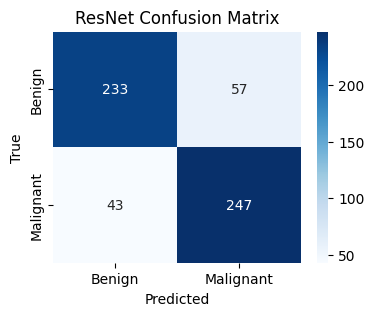

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

model_resnet, input_size = initialize_model("resnet", 2, use_pretrained=True, pretrained_path='/weights/nosegment/resnet_model_weights.txt')
model = model_resnet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Assuming you have the test_loader set up
inputs, outputs, labels, preds = evaluate_model(model, dataloaders['test'], device)

# Calculate accuracy
accuracy = accuracy_score(labels, preds)
print(f'Test Accuracy: {accuracy:.4f}')
accuracies["resnet"] = accuracy

# Generate a classification report
report = classification_report(labels, preds, target_names=['Benign', 'Malignant'], output_dict=True)
print(classification_report(labels, preds, target_names=['Benign', 'Malignant']))

# Confusion Matrix
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ResNet Confusion Matrix')
plt.show()




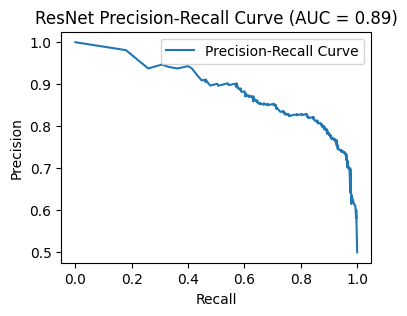

The AUC is 0.89.


In [ ]:
# Set up threshold values
thresholds = np.linspace(0, 1, 1000)
pairs = []

# Calculate TP, FP, TN, FN at each threshold
for threshold in thresholds:
    TP = FP = FN = TN = 0
    for true_label, output in zip(labels, outputs):
        prob = torch.nn.functional.softmax(torch.tensor(output), dim=0)[1]  # Convert logits to probabilities for class 1
        if prob >= threshold:
            if true_label == 1:
                TP += 1
            else:
                FP += 1
        else:
            if true_label == 1:
                FN += 1
            else:
                TN += 1

    precision = 1 if TP + FP == 0 else TP / (TP + FP)
    recall = 0 if TP + FN == 0 else TP / (TP + FN)
    pairs.append((recall, precision))

# Sorting by recall to ensure proper AUC calculation
pairs.sort(key=lambda x: x[0])
recallL, precisionL = zip(*pairs)

# Calculate AUC using the trapezoidal rule
auc_value = np.trapz(precisionL, recallL)

# Plotting
plt.figure(figsize=(4,3))
plt.plot(recallL, precisionL, label=f'Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'ResNet Precision-Recall Curve (AUC = {auc_value:.2f})')
plt.legend()
plt.show()

print(f"The AUC is {auc_value:.2f}.")


In [ ]:
# Saving the model
weight_dir = '/weights/nosegment'
torch.save(model.state_dict(), os.path.join(weight_dir, 'resnet_model_weights.txt'))

# To load the model
model.load_state_dict(torch.load(os.path.join(weight_dir, 'resnet_model_weights.txt')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## AlexNet

In [ ]:
# Setup
images_dir = os.path.join(data_dir, 'HAM10000_images_folder')  # Path to the directory containing images
batch_size = 32
model_name = 'alexnet'
num_classes = 2  # Set this to the number of your classes

# Initialize model
model_alexnet, input_size = initialize_model(model_name, num_classes, use_pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_alexnet.parameters(), lr=0.001, momentum=0.9)

# Train the model
model_alexnet = train_model(model_alexnet, dataloaders, criterion, optimizer, num_epochs=25)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 129MB/s]


Epoch 1/25
Batch 1/86
Batch 2/86
Batch 3/86
Batch 4/86
Batch 5/86
Batch 6/86
Batch 7/86
Batch 8/86
Batch 9/86
Batch 10/86
Batch 11/86
Batch 12/86
Batch 13/86
Batch 14/86
Batch 15/86
Batch 16/86
Batch 17/86
Batch 18/86
Batch 19/86
Batch 20/86
Batch 21/86
Batch 22/86
Batch 23/86
Batch 24/86
Batch 25/86
Batch 26/86
Batch 27/86
Batch 28/86
Batch 29/86
Batch 30/86
Batch 31/86
Batch 32/86
Batch 33/86
Batch 34/86
Batch 35/86
Batch 36/86
Batch 37/86
Batch 38/86
Batch 39/86
Batch 40/86
Batch 41/86
Batch 42/86
Batch 43/86
Batch 44/86
Batch 45/86
Batch 46/86
Batch 47/86
Batch 48/86
Batch 49/86
Batch 50/86
Batch 51/86
Batch 52/86
Batch 53/86
Batch 54/86
Batch 55/86
Batch 56/86
Batch 57/86
Batch 58/86
Batch 59/86
Batch 60/86
Batch 61/86
Batch 62/86
Batch 63/86
Batch 64/86
Batch 65/86
Batch 66/86
Batch 67/86
Batch 68/86
Batch 69/86
Batch 70/86
Batch 71/86
Batch 72/86
Batch 73/86
Batch 74/86
Batch 75/86
Batch 76/86
Batch 77/86
Batch 78/86
Batch 79/86
Batch 80/86
Batch 81/86
Batch 82/86
Batch 83/86
Ba

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 0.8190
              precision    recall  f1-score   support

      Benign       0.91      0.71      0.80       290
   Malignant       0.76      0.93      0.84       290

    accuracy                           0.82       580
   macro avg       0.84      0.82      0.82       580
weighted avg       0.84      0.82      0.82       580



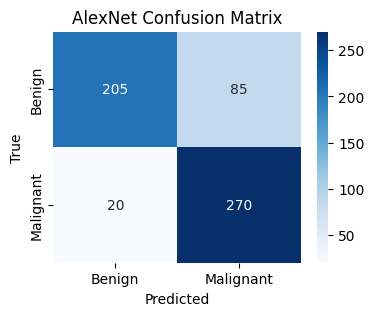

In [ ]:
# model, input_size = initialize_model("alexnet", num_classes, use_pretrained=True)
# model.load_state_dict(torch.load('/weights/data imbalance/alexnet_model_weights.txt'))
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

model_alexnet, input_size = initialize_model("alexnet", 2, use_pretrained=True, pretrained_path='/weights/nosegment/alexnet_model_weights.txt')
model = model_alexnet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Assuming you have the test_loader set up
inputs, outputs, labels, preds = evaluate_model(model, dataloaders['test'], device)

# Calculate accuracy
accuracy = accuracy_score(labels, preds)
print(f'Test Accuracy: {accuracy:.4f}')
accuracies["alexnet"] = accuracy

# Generate a classification report
report = classification_report(labels, preds, target_names=['Benign', 'Malignant'], output_dict=True)
print(classification_report(labels, preds, target_names=['Benign', 'Malignant']))

# Confusion Matrix
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('AlexNet Confusion Matrix')
plt.show()

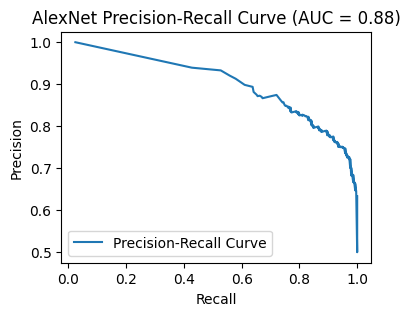

The AUC is 0.88.


In [ ]:
# Set up threshold values
thresholds = np.linspace(0, 1, 1000)
pairs = []

# Calculate TP, FP, TN, FN at each threshold
for threshold in thresholds:
    TP = FP = FN = TN = 0
    for true_label, output in zip(labels, outputs):
        prob = torch.nn.functional.softmax(torch.tensor(output), dim=0)[1]  # Convert logits to probabilities for class 1
        if prob >= threshold:
            if true_label == 1:
                TP += 1
            else:
                FP += 1
        else:
            if true_label == 1:
                FN += 1
            else:
                TN += 1

    precision = 1 if TP + FP == 0 else TP / (TP + FP)
    recall = 0 if TP + FN == 0 else TP / (TP + FN)
    pairs.append((recall, precision))

# Sorting by recall to ensure proper AUC calculation
pairs.sort(key=lambda x: x[0])
recallL, precisionL = zip(*pairs)

# Calculate AUC using the trapezoidal rule
auc_value = np.trapz(precisionL, recallL)

# Plotting
plt.figure(figsize=(4,3))
plt.plot(recallL, precisionL, label=f'Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'AlexNet Precision-Recall Curve (AUC = {auc_value:.2f})')
plt.legend()
plt.show()

print(f"The AUC is {auc_value:.2f}.")

In [ ]:
# Saving the model
weight_dir = '/weights/nosegment'
torch.save(model_alexnet.state_dict(), os.path.join(weight_dir, 'alexnet_model_weights.txt'))

# To load the model
model_alexnet.load_state_dict(torch.load(os.path.join(weight_dir, 'alexnet_model_weights.txt')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## VGG

In [ ]:
# Setup
images_dir = os.path.join(data_dir, 'HAM10000_images_folder')  # Path to the directory containing images
batch_size = 32
model_name = 'vgg'
num_classes = 2  # Set this to the number of your classes

# Initialize model
vgg_model, input_size = initialize_model(model_name, num_classes, use_pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)

# Train the model
model_vgg = train_model(vgg_model, dataloaders, criterion, optimizer, num_epochs=25)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 136MB/s]


Epoch 1/25
Batch 1/86
Batch 2/86
Batch 3/86
Batch 4/86
Batch 5/86
Batch 6/86
Batch 7/86
Batch 8/86
Batch 9/86
Batch 10/86
Batch 11/86
Batch 12/86
Batch 13/86
Batch 14/86
Batch 15/86
Batch 16/86
Batch 17/86
Batch 18/86
Batch 19/86
Batch 20/86
Batch 21/86
Batch 22/86
Batch 23/86
Batch 24/86
Batch 25/86
Batch 26/86
Batch 27/86
Batch 28/86
Batch 29/86
Batch 30/86
Batch 31/86
Batch 32/86
Batch 33/86
Batch 34/86
Batch 35/86
Batch 36/86
Batch 37/86
Batch 38/86
Batch 39/86
Batch 40/86
Batch 41/86
Batch 42/86
Batch 43/86
Batch 44/86
Batch 45/86
Batch 46/86
Batch 47/86
Batch 48/86
Batch 49/86
Batch 50/86
Batch 51/86
Batch 52/86
Batch 53/86
Batch 54/86
Batch 55/86
Batch 56/86
Batch 57/86
Batch 58/86
Batch 59/86
Batch 60/86
Batch 61/86
Batch 62/86
Batch 63/86
Batch 64/86
Batch 65/86
Batch 66/86
Batch 67/86
Batch 68/86
Batch 69/86
Batch 70/86
Batch 71/86
Batch 72/86
Batch 73/86
Batch 74/86
Batch 75/86
Batch 76/86
Batch 77/86
Batch 78/86
Batch 79/86
Batch 80/86
Batch 81/86
Batch 82/86
Batch 83/86
Ba

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 0.8534
              precision    recall  f1-score   support

      Benign       0.89      0.80      0.85       290
   Malignant       0.82      0.90      0.86       290

    accuracy                           0.85       580
   macro avg       0.86      0.85      0.85       580
weighted avg       0.86      0.85      0.85       580



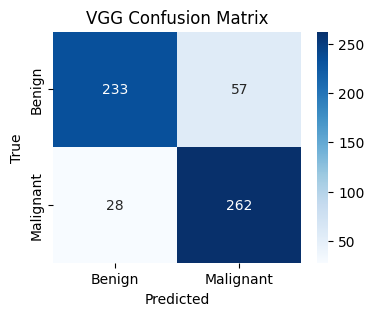

In [ ]:
# model, input_size = initialize_model("vgg", num_classes, use_pretrained=True)
# model.load_state_dict(torch.load('/weights/nosegment/vgg_model_weights.txt'))
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

model_vgg, input_size = initialize_model("vgg", 2, use_pretrained=True, pretrained_path='/weights/nosegment/vgg_model_weights.txt')
model = model_vgg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Assuming you have the test_loader set up
inputs, outputs, labels, preds = evaluate_model(model, dataloaders['test'], device)

# Calculate accuracy
accuracy = accuracy_score(labels, preds)
print(f'Test Accuracy: {accuracy:.4f}')
accuracies["vgg"] = accuracy

# Generate a classification report
report = classification_report(labels, preds, target_names=['Benign', 'Malignant'], output_dict=True)
print(classification_report(labels, preds, target_names=['Benign', 'Malignant']))

# Confusion Matrix
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('VGG Confusion Matrix')
plt.show()

(0.28620689655172415, 0.9540229885057471)


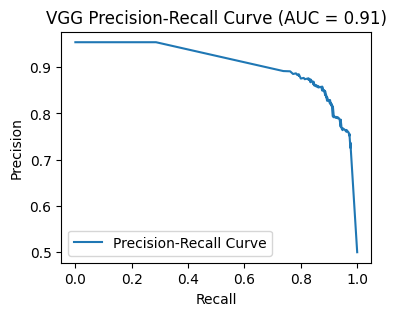

The AUC is 0.91.


In [ ]:
from sklearn.metrics import auc

# Set up threshold values
thresholds = np.linspace(0, 1, 1000)
pairs = []
precisionL = []
recallL = []

# Calculate TP, FP, TN, FN at each threshold
for threshold in thresholds:
    TP = FP = FN = TN = 0
    for true_label, output in zip(labels, outputs):
        prob = torch.nn.functional.softmax(torch.tensor(output), dim=0)[1]  # Convert logits to probabilities for class 1
        if prob >= threshold:
            if true_label == 1:
                TP += 1
            else:
                FP += 1
        else:
            if true_label == 1:
                FN += 1
            else:
                TN += 1

    precision = 1 if TP + FP == 0 else TP / (TP + FP)
    recall = 0 if TP + FN == 0 else TP / (TP + FN)
    pairs.append((recall, precision))

# Sorting by recall to ensure proper AUC calculation
pairs.sort(key=lambda x: x[0])
print(pairs[0])
recallL, precisionL = zip(*pairs)
extended_recalls = np.insert(recallL, 0, 0.0)  # Insert 0 at the start of the recall array
extended_precisions = np.insert(precisionL, 0, precisionL[0])

# Calculate AUC using the trapezoidal rule
auc_value = auc(extended_recalls, extended_precisions)

# Plotting
plt.figure(figsize=(4, 3))
plt.plot(extended_recalls, extended_precisions, label=f'Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'VGG Precision-Recall Curve (AUC = {auc_value:.2f})')
plt.legend()
plt.show()

print(f"The AUC is {auc_value:.2f}.")

In [ ]:
# Saving the model
weight_dir = '/weights/nosegment'
torch.save(model.state_dict(), os.path.join(weight_dir, 'vgg_model_weights.txt'))

# To load the model
model.load_state_dict(torch.load(os.path.join(weight_dir, 'vgg_model_weights.txt')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## DenseNet

In [ ]:
# Setup
images_dir = os.path.join(data_dir, 'HAM10000_images_folder')  # Path to the directory containing images
batch_size = 32
model_name = 'densenet'
num_classes = 2  # Set this to the number of your classes

# Initialize model
dense_model, input_size = initialize_model(model_name, num_classes, use_pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dense_model.parameters(), lr=0.001, momentum=0.9)

# Train the model
model_densenet = train_model(dense_model, dataloaders, criterion, optimizer, num_epochs=25)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 98.1MB/s]


Epoch 1/25
Batch 1/86
Batch 2/86
Batch 3/86
Batch 4/86
Batch 5/86
Batch 6/86
Batch 7/86
Batch 8/86
Batch 9/86
Batch 10/86
Batch 11/86
Batch 12/86
Batch 13/86
Batch 14/86
Batch 15/86
Batch 16/86
Batch 17/86
Batch 18/86
Batch 19/86
Batch 20/86
Batch 21/86
Batch 22/86
Batch 23/86
Batch 24/86
Batch 25/86
Batch 26/86
Batch 27/86
Batch 28/86
Batch 29/86
Batch 30/86
Batch 31/86
Batch 32/86
Batch 33/86
Batch 34/86
Batch 35/86
Batch 36/86
Batch 37/86
Batch 38/86
Batch 39/86
Batch 40/86
Batch 41/86
Batch 42/86
Batch 43/86
Batch 44/86
Batch 45/86
Batch 46/86
Batch 47/86
Batch 48/86
Batch 49/86
Batch 50/86
Batch 51/86
Batch 52/86
Batch 53/86
Batch 54/86
Batch 55/86
Batch 56/86
Batch 57/86
Batch 58/86
Batch 59/86
Batch 60/86
Batch 61/86
Batch 62/86
Batch 63/86
Batch 64/86
Batch 65/86
Batch 66/86
Batch 67/86
Batch 68/86
Batch 69/86
Batch 70/86
Batch 71/86
Batch 72/86
Batch 73/86
Batch 74/86
Batch 75/86
Batch 76/86
Batch 77/86
Batch 78/86
Batch 79/86
Batch 80/86
Batch 81/86
Batch 82/86
Batch 83/86
Ba

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 103MB/s]


Test Accuracy: 0.8310
              precision    recall  f1-score   support

      Benign       0.85      0.80      0.83       290
   Malignant       0.81      0.86      0.84       290

    accuracy                           0.83       580
   macro avg       0.83      0.83      0.83       580
weighted avg       0.83      0.83      0.83       580



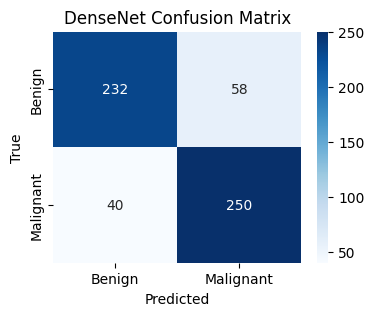

In [ ]:
model_densenet, input_size = initialize_model("densenet", 2, use_pretrained=True, pretrained_path='/weights/nosegment/densenet_model_weights.txt')
model = model_densenet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Assuming you have the test_loader set up
inputs, outputs, labels, preds = evaluate_model(model, dataloaders['test'], device)

# Calculate accuracy
accuracy = accuracy_score(labels, preds)
print(f'Test Accuracy: {accuracy:.4f}')
accuracies["densenet"] = accuracy

# Generate a classification report
report = classification_report(labels, preds, target_names=['Benign', 'Malignant'], output_dict=True)
print(classification_report(labels, preds, target_names=['Benign', 'Malignant']))

# Confusion Matrix
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('DenseNet Confusion Matrix')
plt.show()

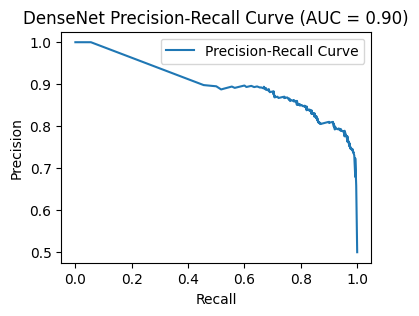

The AUC is 0.90.


In [ ]:
from sklearn.metrics import auc

# Set up threshold values
thresholds = np.linspace(0, 1, 1000)
pairs = []

# Calculate TP, FP, TN, FN at each threshold
for threshold in thresholds:
    TP = FP = FN = TN = 0
    for true_label, output in zip(labels, outputs):
        prob = torch.nn.functional.softmax(torch.tensor(output), dim=0)[1]  # Convert logits to probabilities for class 1
        if prob >= threshold:
            if true_label == 1:
                TP += 1
            else:
                FP += 1
        else:
            if true_label == 1:
                FN += 1
            else:
                TN += 1

    precision = 1 if TP + FP == 0 else TP / (TP + FP)
    recall = 0 if TP + FN == 0 else TP / (TP + FN)
    pairs.append((recall, precision))

# Sorting by recall to ensure proper AUC calculation
pairs.sort(key=lambda x: x[0])
recallL, precisionL = zip(*pairs)
extended_recalls = np.insert(recallL, 0, 0.0)  # Insert 0 at the start of the recall array
extended_precisions = np.insert(precisionL, 0, precisionL[0])  # Extend precision horizontally


# Calculate AUC using the trapezoidal rule
auc_value = auc(extended_recalls, extended_precisions)

# Plotting
plt.figure(figsize=(4, 3))
plt.plot(extended_recalls, extended_precisions, label=f'Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'DenseNet Precision-Recall Curve (AUC = {auc_value:.2f})')
plt.legend()
plt.show()

print(f"The AUC is {auc_value:.2f}.")

In [ ]:
# Saving the model
weight_dir = '/weights/nosegment'
torch.save(model.state_dict(), os.path.join(weight_dir, 'densenet_model_weights.txt'))

# To load the model
model.load_state_dict(torch.load(os.path.join(weight_dir, 'densenet_model_weights.txt')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Ensemble

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def ensemble_predict(models, dataloaders, weights, device, threshold=0.5):
    ensemble_scores = np.zeros(len(dataloaders['test'].dataset))
    total_weights = sum(weights)

    for i, model in enumerate(models):
        model.to(device)  # Change 'model' to 'models[i]'
        model.eval()
        predictions = []

        with torch.no_grad():
            for inputs, _ in dataloaders['test']:
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds = torch.max(outputs, 1)[1]
                predictions.extend(preds.cpu().numpy())

        weighted_predictions = np.array(predictions) * weights[i]
        ensemble_scores += weighted_predictions

    # Normalize the scores by the total weights and apply threshold
    ensemble_scores /= total_weights
    ensemble_predictions = (ensemble_scores >= threshold).astype(int)
    return ensemble_predictions


def get_true_labels(dataloader):
    """ Collect all labels from the dataloader for comparison with predictions. """
    true_labels = []
    for _, labels in dataloader:
        true_labels.extend(labels.numpy())
    return np.array(true_labels)



In [ ]:
def evaluate_ensemble(models, dataloaders, weights, device='cuda', threshold=0.5):
    true_labels = get_true_labels(dataloaders['test'])
    preds = ensemble_predict(models, dataloaders, weights, device, threshold)

    accuracy = accuracy_score(true_labels, preds)
    print(f'Ensemble Test Accuracy: {accuracy:.4f}')

    conf_matrix = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix of Ensemble')
    plt.show()

    precision, recall, _ = precision_recall_curve(true_labels, preds)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(4, 3))
    plt.plot(recall, precision, label=f'Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve of Ensemble (AUC = {pr_auc:.2f})')
    plt.legend()
    plt.show()




In [ ]:
# List of models
accuracies = {}
accuracies["resnet"] = 0.8276
accuracies["alexnet"] = 0.8190
accuracies["vgg"] = 0.8534
accuracies["densenet"] = 0.8310
weight_dir = '/weights/nosegment'
model_resnet, input_size = initialize_model("resnet", 2, use_pretrained=True, pretrained_path=os.path.join(weight_dir, 'resnet_model_weights.txt'))
model_alexnet, input_size = initialize_model("alexnet", 2, use_pretrained=True, pretrained_path=os.path.join(weight_dir, 'alexnet_model_weights.txt'))
model_vgg, input_size = initialize_model("vgg", 2, use_pretrained=True, pretrained_path=os.path.join(weight_dir, 'vgg_model_weights.txt'))
model_densenet, input_size = initialize_model("densenet", 2, use_pretrained=True, pretrained_path=os.path.join(weight_dir, 'densenet_model_weights.txt'))
models_list = [model_resnet, model_alexnet, model_vgg, model_densenet]  # Replace with your actual models
weights = [accuracies['resnet'], accuracies['alexnet'], accuracies['vgg'], accuracies['densenet']]  # Replace with your weights

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ensemble Test Accuracy: 0.8552


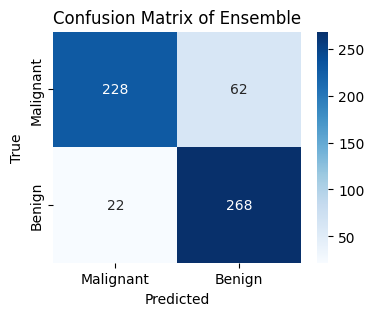

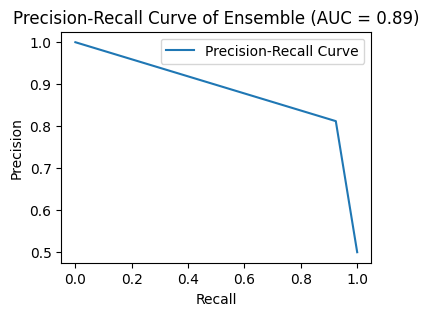

In [ ]:
# Call the evaluation
evaluate_ensemble(models_list, dataloaders, weights)

## ResNet 152

In [ ]:
# Setup
images_dir = os.path.join(data_dir, 'HAM10000_images_folder')  # Path to the directory containing images
batch_size = 32
model_name = 'resnet152'
num_classes = 2  # Set this to the number of your classes

# Initialize model
resnet152_model, input_size = initialize_model(model_name, num_classes, use_pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet152_model.parameters(), lr=0.001, momentum=0.9)

# Train the model
model_resnet152 = train_model(resnet152_model, dataloaders, criterion, optimizer, num_epochs=25)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 139MB/s]


Epoch 1/25
Batch 1/86
Batch 2/86
Batch 3/86
Batch 4/86
Batch 5/86
Batch 6/86
Batch 7/86
Batch 8/86
Batch 9/86
Batch 10/86
Batch 11/86
Batch 12/86
Batch 13/86
Batch 14/86
Batch 15/86
Batch 16/86
Batch 17/86
Batch 18/86
Batch 19/86
Batch 20/86
Batch 21/86
Batch 22/86
Batch 23/86
Batch 24/86
Batch 25/86
Batch 26/86
Batch 27/86
Batch 28/86
Batch 29/86
Batch 30/86
Batch 31/86
Batch 32/86
Batch 33/86
Batch 34/86
Batch 35/86
Batch 36/86
Batch 37/86
Batch 38/86
Batch 39/86
Batch 40/86
Batch 41/86
Batch 42/86
Batch 43/86
Batch 44/86
Batch 45/86
Batch 46/86
Batch 47/86
Batch 48/86
Batch 49/86
Batch 50/86
Batch 51/86
Batch 52/86
Batch 53/86
Batch 54/86
Batch 55/86
Batch 56/86
Batch 57/86
Batch 58/86
Batch 59/86
Batch 60/86
Batch 61/86
Batch 62/86
Batch 63/86
Batch 64/86
Batch 65/86
Batch 66/86
Batch 67/86
Batch 68/86
Batch 69/86
Batch 70/86
Batch 71/86
Batch 72/86
Batch 73/86
Batch 74/86
Batch 75/86
Batch 76/86
Batch 77/86
Batch 78/86
Batch 79/86
Batch 80/86
Batch 81/86
Batch 82/86
Batch 83/86
Ba

Test Accuracy: 0.8621
              precision    recall  f1-score   support

      Benign       0.88      0.84      0.86       290
   Malignant       0.85      0.89      0.87       290

    accuracy                           0.86       580
   macro avg       0.86      0.86      0.86       580
weighted avg       0.86      0.86      0.86       580



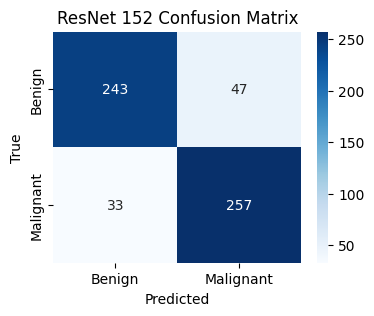

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

model = model_resnet152
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Assuming you have the test_loader set up
inputs, outputs, labels, preds = evaluate_model(model, dataloaders['test'], device)

# Calculate accuracy
accuracy = accuracy_score(labels, preds)
print(f'Test Accuracy: {accuracy:.4f}')
accuracies["resnet"] = accuracy

# Generate a classification report
report = classification_report(labels, preds, target_names=['Benign', 'Malignant'], output_dict=True)
print(classification_report(labels, preds, target_names=['Benign', 'Malignant']))

# Confusion Matrix
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ResNet 152 Confusion Matrix')
plt.show()


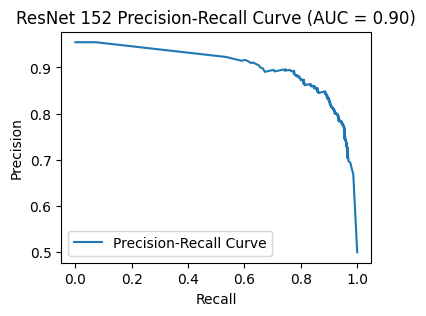

The AUC is 0.90.


In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Set up threshold values
thresholds = np.linspace(0, 1, 1000)
pairs = []

# Calculate TP, FP, TN, FN at each threshold
for threshold in thresholds:
    TP = FP = FN = TN = 0
    for true_label, output in zip(labels, outputs):
        prob = torch.nn.functional.softmax(torch.tensor(output), dim=0)[1]  # Convert logits to probabilities for class 1
        if prob >= threshold:
            if true_label == 1:
                TP += 1
            else:
                FP += 1
        else:
            if true_label == 1:
                FN += 1
            else:
                TN += 1

    precision = 1 if TP + FP == 0 else TP / (TP + FP)
    recall = 0 if TP + FN == 0 else TP / (TP + FN)
    pairs.append((recall, precision))

# Sorting by recall to ensure proper AUC calculation
pairs.sort(key=lambda x: x[0])
recallL, precisionL = zip(*pairs)

# Extend the recall and precision arrays
extended_recalls = np.insert(recallL, 0, 0.0)  # Insert 0 at the start of the recall array
extended_precisions = np.insert(precisionL, 0, precisionL[0])  # Extend precision horizontally

# Calculate AUC
auc_value = auc(extended_recalls, extended_precisions)

# Plotting
plt.figure(figsize=(4, 3))
plt.plot(extended_recalls, extended_precisions, label=f'Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'ResNet 152 Precision-Recall Curve (AUC = {auc_value:.2f})')
plt.legend()
plt.show()

print(f"The AUC is {auc_value:.2f}.")

In [ ]:
# Saving the model
weight_dir = '/weights/nosegment'
torch.save(model.state_dict(), os.path.join(weight_dir, 'resnet_152_model_weights.txt'))

# To load the model
model.load_state_dict(torch.load(os.path.join(weight_dir, 'resnet_152_model_weights.txt')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 